# Data exploration for Capstone 2

Exploring the labels and images included in the [Lemons dataset](https://github.com/softwaremill/lemon-dataset).

The annotations are contained in a .json file. It has simple classification targets as well as semantic segmentation of additional quality (both image and fruit) targets.

### The Data
The data is contained within two folders - one with images and one with the annotations .json file. 

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from skimage import io, color, filters
from skimage.transform import resize, rotate
from skimage.filters import sobel
import seaborn as sns

ImportError: cannot import name 'canny' from 'skimage.filters' (/home/soultrain/anaconda3/lib/python3.7/site-packages/skimage/filters/__init__.py)

In [2]:
# use ggplot style
# plt.style.use('ggplot')

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}

# example of keyword argument unpacking
plt.rc('font', **font)
plot_size = (10, 10)

chart_color = 'm'

In [3]:
coco = COCO('../data/raw/annotations/instances_default.json')

loading annotations into memory...
Done (t=0.96s)
creating index...
index created!


### Let's look at our categories

Make a dictionary to map image ids to file names

In [4]:
catIds = coco.loadCats()
imgIds = coco.getImgIds(catIds=catIds)
# imgIds = coco.getImgIds(imgIds=['id'])
img = coco.loadImgs(imgIds)
img[0]

{'id': 0,
 'date_captured': 0,
 'coco_url': '',
 'file_name': 'images/0001_A_H_0_A.jpg',
 'license': 0,
 'flickr_url': '',
 'height': 1056,
 'width': 1056}

In [5]:
to_del = ['date_captured', 'coco_url', 'license', 'flickr_url', 'height', 'width']

In [6]:
images_df = pd.DataFrame.from_dict(img).set_index('id').drop(to_del, axis=1)
images_df.rename_axis('image', inplace=True)
images_df.head()

,file_name
image,
0,images/0001_A_H_0_A.jpg
100,images/0003_A_V_150_A.jpg
101,images/0003_A_V_15_A.jpg
102,images/0003_A_V_165_A.jpg
103,images/0003_A_V_30_A.jpg


### Drop the unused 'supercategory' field

In [7]:
cats = coco.loadCats(coco.getCatIds())

In [8]:
cats

[{'id': 1, 'supercategory': '', 'name': 'image_quality'},
 {'id': 2, 'supercategory': '', 'name': 'illness'},
 {'id': 3, 'supercategory': '', 'name': 'gangrene'},
 {'id': 4, 'supercategory': '', 'name': 'mould'},
 {'id': 5, 'supercategory': '', 'name': 'blemish'},
 {'id': 6, 'supercategory': '', 'name': 'dark_style_remains'},
 {'id': 7, 'supercategory': '', 'name': 'artifact'},
 {'id': 8, 'supercategory': '', 'name': 'condition'},
 {'id': 9, 'supercategory': '', 'name': 'pedicel'}]

### Make it a dataframe!

In [9]:
cats_df = pd.DataFrame.from_dict(cats).set_index('id').drop('supercategory', axis=1)
cats_df

,name
id,
1,image_quality
2,illness
3,gangrene
4,mould
5,blemish
6,dark_style_remains
7,artifact
8,condition
9,pedicel


### Let's look at our annotations

A single annotation

In [10]:
anns = coco.loadAnns(coco.getAnnIds())
anns[5].keys()

dict_keys(['id', 'iscrowd', 'area', 'category_id', 'image_id', 'segmentation', 'bbox'])

In [11]:
anns_df = pd.DataFrame.from_dict(anns).set_index('id').drop('iscrowd', axis=1)
anns_df.rename(columns={'image_id': 'image', 'category_id': 'category'}, inplace=True)
# anns_df.rename_axis('ann_num', inplace=True)
anns_df.head()

,area,category,image,segmentation,bbox
id,,,,,
1,539.0,9,0,"[[179.15200000000914, 641.3920000000107, 179.0...","[157.40800000001036, 603.6640000000098, 27.215..."
2,622.0,5,0,"[[411.404296875, 458.1650390625, 403.939548160...","[398.2661785600103, 422.66166784001143, 29.561..."
3,809.0,5,0,"[[299.818359375, 442.6376953125, 293.547719680...","[291.15893248000975, 431.8883584000105, 39.414..."
4,30.0,5,100,"[[311.98046875, 494.6767578125, 308.9262595362...","[308.92625953626884, 494.6767578125, 6.2998631..."
5,31.0,2,100,"[[606.7744140625, 489.2041015625, 602.81602149...","[602.8160214904838, 489.2041015625, 7.58732610..."


In [12]:
output = anns_df.join(images_df, on='image').drop(['area', 'segmentation', 'bbox'], axis=1)
output.head()

,category,image,file_name
id,,,
1,9,0,images/0001_A_H_0_A.jpg
2,5,0,images/0001_A_H_0_A.jpg
3,5,0,images/0001_A_H_0_A.jpg
4,5,100,images/0003_A_V_150_A.jpg
5,2,100,images/0003_A_V_150_A.jpg


In [13]:
output['target'] = 0
output.head()

,category,image,file_name,target
id,,,,
1,9,0,images/0001_A_H_0_A.jpg,0
2,5,0,images/0001_A_H_0_A.jpg,0
3,5,0,images/0001_A_H_0_A.jpg,0
4,5,100,images/0003_A_V_150_A.jpg,0
5,2,100,images/0003_A_V_150_A.jpg,0


In [14]:
out_dict = {'image': [], 'file_name': [], 'target': []}

com = [2, 3, 5, 6]
bad = [4]

grouped = output.groupby('image')
image_list = grouped.image.unique()
for i in image_list:
    sub_group = grouped.get_group(int(i))
    image_categories = sub_group.category.unique()

    if np.any(np.isin(bad, image_categories)):
        target_ = 0
    elif np.any(np.isin(com, image_categories)):
        target_ = 1
    else:
        target_ = 2

    out_dict['image'].append(sub_group.iloc[0]['image'])
    out_dict['file_name'].append(sub_group.iloc[0]['file_name'])
#     print(sub_group.iloc[0]['file_name'])
    out_dict['target'].append(target_)

y = np.asarray(out_dict['target'])
filenames = out_dict['file_name']
image_ids = out_dict['image']

In [15]:
y_list = [i for i in zip(filenames, y)]
# for i in zip(filenames, y):
#     y_list.append(i)
dy = dict(sorted(y_list))
sorted_dict = {'target': list(dy.values()), 'filenames': list(dy.keys())}

In [16]:
f = []
for i, _ in enumerate(anns):
    f.append(anns[i]['image_id'])
x = np.array(f)
len(np.unique(x))

2690

(-0.5, 1055.5, 1055.5, -0.5)

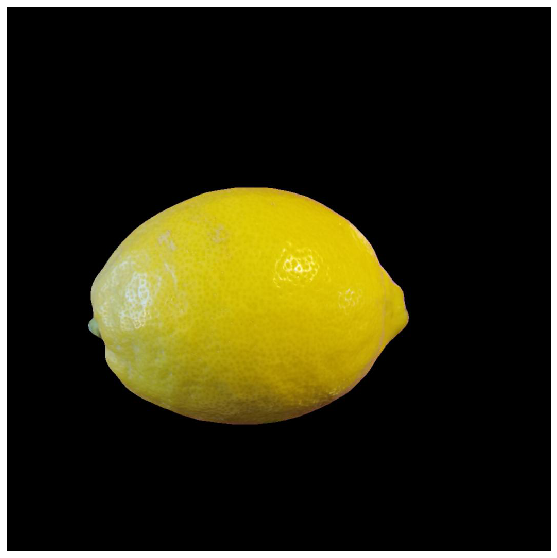

In [17]:
one = io.imread('../data/raw/images/0001_A_H_0_A.jpg')
fig, ax = plt.subplots(figsize=plot_size)
ax.imshow(one)
ax.axis('off')

In [18]:
# load and display instance annotations
# plt.imshow(one); plt.axis('off')
# ax = plt.gca()
# annIds = coco.getAnnIds(imgIds=one['id'], catIds=cats, iscrowd=None)
# anns = coco.loadAnns(annIds)
# coco.showAnns(anns)

## Load the images!

In [19]:
cat_ids = coco.getCatIds(catNms=['artifact'])
img_ids = coco.getImgIds(catIds=cat_ids)
len(img_ids)

451

(-0.5, 1055.5, 1055.5, -0.5)

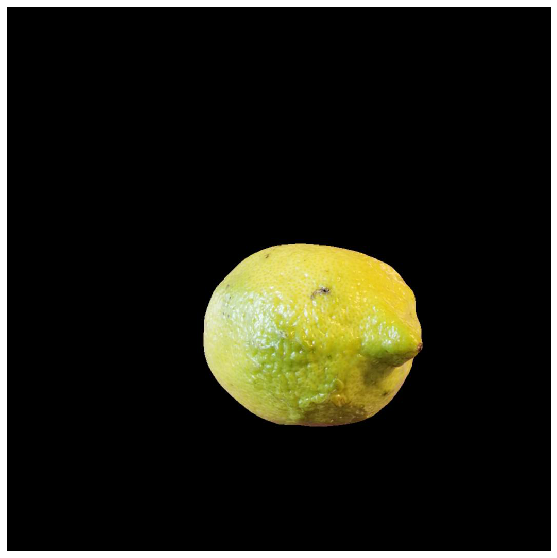

In [20]:
I = io.imread('../data/raw/images/0001_E_H_0_C.jpg')
fig, ax = plt.subplots(figsize=plot_size)
ax.imshow(I)
ax.axis('off')

In [21]:
I.shape

(1056, 1056, 3)

(-0.5, 1055.5, 1055.5, -0.5)

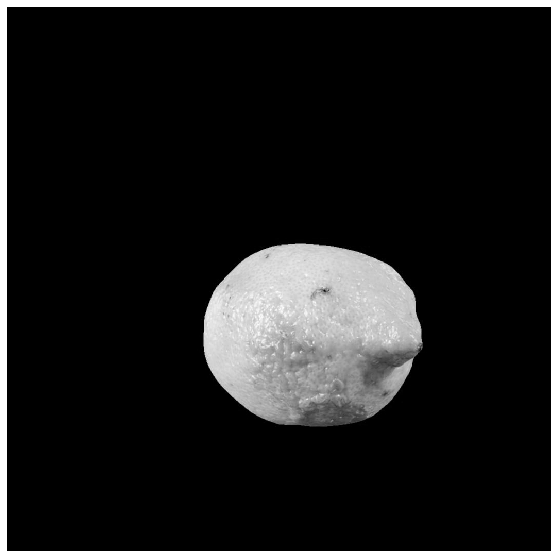

In [22]:
g = color.rgb2gray(I)
fig, ax = plt.subplots(figsize=plot_size)
ax.imshow(g, cmap='gray')
ax.axis('off')

In [23]:
flat = g.flatten(order='C')
flat.mean()

0.07626559326730148

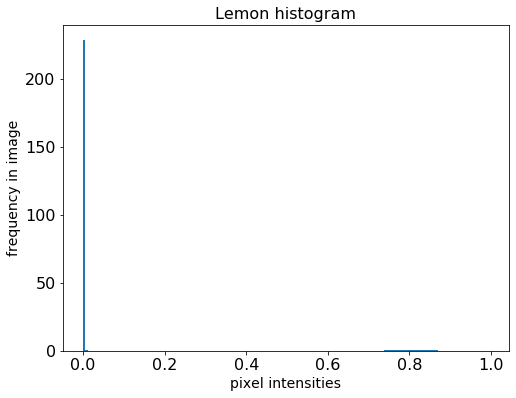

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.hist(np.ravel(g), bins=256, density=True)
ax.set_xlabel('pixel intensities', fontsize=14)
ax.set_ylabel('frequency in image', fontsize=14)
ax.set_title("Lemon histogram", fontsize=16);

## Image EDA

(-0.5, 1055.5, 1055.5, -0.5)

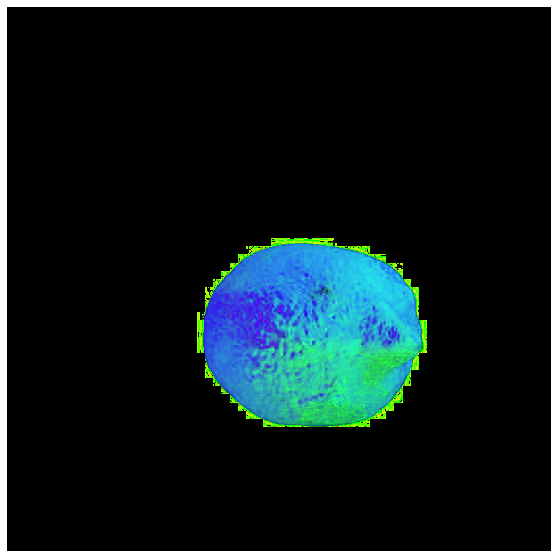

In [25]:
img_hsv = color.rgb2hsv(I)
fig, ax = plt.subplots(figsize=plot_size)
ax.imshow(img_hsv)
ax.axis('off')

A space lemon?!?!

In [43]:
hue_img = img_hsv[:, :, 0]
val_img = img_hsv[:, :, 2]
yellows = [42/360, 64/360]

In [44]:
mask = (val_img > 0.1) & ((hue_img < yellows[1]) & (hue_img > yellows[0]))
mask.shape

(1056, 1056)

With the colors limited to yellow hues and the brightness shifted above the black background

In [45]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

(-0.5, 1055.5, 1055.5, -0.5)

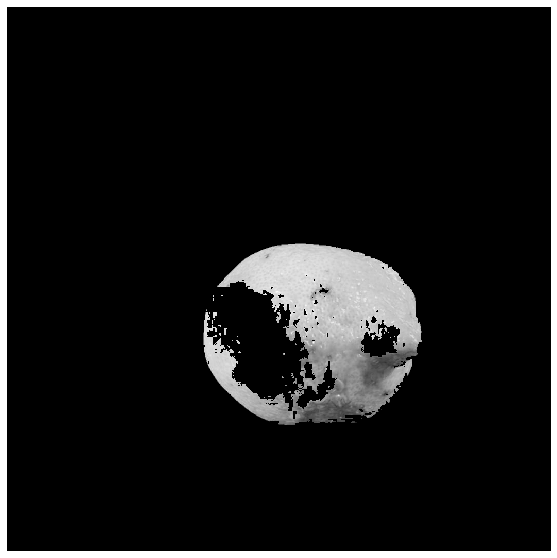

In [47]:
fig, ax = plt.subplots(figsize=plot_size)
masked_image = g * mask
ax.imshow(masked_image, cmap='gray')
ax.axis('off')

With a mask blocking extreme dark values and colors outside the orange-yellow to yellow hue range

In [48]:
masked_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

(-0.5, 127.5, 127.5, -0.5)

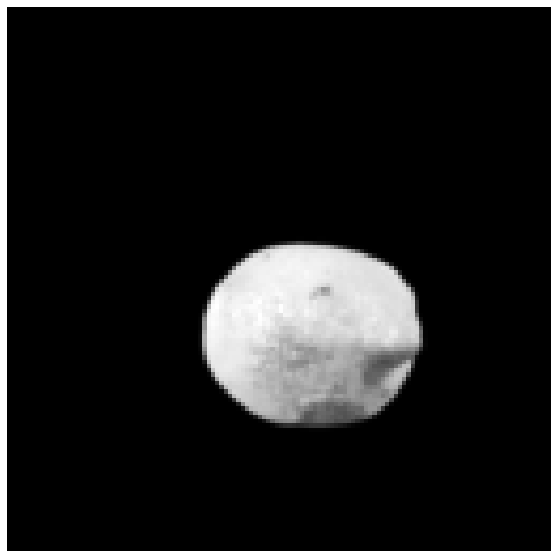

In [63]:
small_gray_lemon = np.asarray(resize(g, (128, 128), anti_aliasing=True))
fig, ax = plt.subplots(figsize=plot_size)
ax.imshow(small_gray_lemon, cmap='gray')
ax.axis('off')

(-0.5, 127.5, 127.5, -0.5)

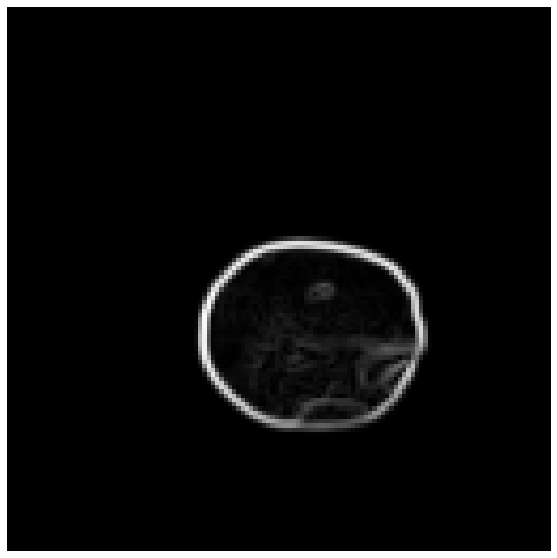

In [66]:
from skimage.feature import canny
edges = sobel(small_gray_lemon)

fig, ax = plt.subplots(figsize=plot_size)
ax.imshow(edges, cmap='gray')
ax.axis('off')

In [68]:
edges.ravel()

array([0., 0., 0., ..., 0., 0., 0.])

In [31]:
# fig, ax = plt.subplots(figsize=plot_size)
plt.scatter(train_img[:, 0], train_img[:, 1],
            edgecolor='none', alpha=0.5,
            cmap='spring')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

NameError: name 'train_img' is not defined

## Cost/Benefit matrix

In [32]:
cb = pd.DataFrame(np.array([[0.06, 0.03], [0, 0.03]]), index=['Retail', 'Commercial'], columns=['Retail', 'Commercial'])

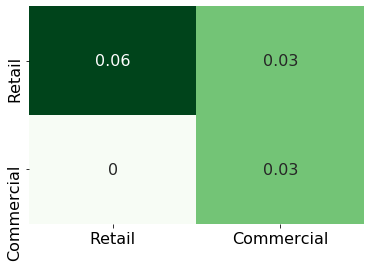

In [33]:
sns.heatmap(cb, annot=True, cmap='Greens', cbar=False)

# Image PCA

In [34]:
import glob
import os

def make_dataset():
    image_dict = {'data': [], 'filename': []}
    xxx = []
    for i, file in enumerate(glob.glob('../data/processed/images/*')):
        fname = file.split('/')[-1]
        img = io.imread(file)
#         gray = color.rgb2gray(img).ravel()
        image_dict['data'].append(img.ravel())
        image_dict['filename'].append(fname)
        
    return np.asarray(image_dict['data']), image_dict['filename']

In [35]:
X, filenames = make_dataset()

In [36]:
lll = []
for i in zip(filenames, X):
    lll.append(i)
o = sorted(lll)
d = dict(o)
io.imshow(d['0004_C_H_60_G.jpg'].reshape(128, 128, 3))

ValueError: cannot reshape array of size 16384 into shape (128,128,3)

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(X[42].reshape(128, 128, 3))
ax.axis

In [37]:
avg_l = np.sum(X, axis=0)

In [38]:
avg_hsv = color.rgb2hsv(avg_l.reshape(128, 128, 3))
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(avg_l.reshape(128, 128, 3))
ax.axis('off')
plt.savefig('../images/average_lemon.jpg')

ValueError: cannot reshape array of size 16384 into shape (128,128,3)

In [39]:
# before scaling
print(f'Before scaling values \n Min: {round(X.min(), 1)} \n Mean: {round(X.mean(), 2)} \n Max: {round(X.max(), 2)} \n Std: {round(X.std(), 2)} \n Shape: {X.shape}')

Before scaling values 
 Min: 0 
 Mean: 26.46 
 Max: 255 
 Std: 61.49 
 Shape: (2690, 16384)


In [40]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)
# transformed = scaler.transform(scaled)

print(f'After scaling values \n Min: {round(X_scaled.min(), 2)} \n Mean: {round(X_scaled.mean(), 2)} \n Max: {round(X_scaled.max(), 2)} \n Std: {round(X_scaled.std(), 2)} \n Shape: {X_scaled.shape}')

After scaling values 
 Min: -6.91 
 Mean: -0.0 
 Max: 51.86 
 Std: 0.88 
 Shape: (2690, 16384)


In [41]:
pca2 = PCA(n_components=0.9)
X_pca = pca2.fit(X_scaled)
X_pca

print(f'Number of components covering 90% variance: {pca2.n_components_}')

Number of components covering 90% variance: 132


In [42]:
print(f'Variance components: {np.around(pca2.explained_variance_[0:6], 1)}')

Variance components: [1501.3 1105.8  685.9  588.7  502.1  435.4]


In [ ]:
# plot explained variance ratio in a scree plot
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plt.title('Variance plots')

ax[0].plot(pca2.explained_variance_, linewidth=3, color='m')
ax[0].axis('tight')
ax[0].set_xlim(0, pca2.n_components_)
ax[0].set_xlabel('n_components')
ax[0].set_ylabel('explained_variance_')

prop_var_expl = np.cumsum(pca2.explained_variance_ratio_)

ax[1].plot(prop_var_expl, color='m', linewidth=3, label='Explained variance')
ax[1].axhline(0.9, label='90% goal', linestyle='--', color="black", linewidth=1)
ax[1].set_ylabel('cumulative prop. of explained variance')
ax[1].set_xlim(0, pca2.n_components_ + 3)
ax[1].set_xlabel('number of principal components')
ax[1].legend(loc='lower right')

In [ ]:
train_img = pca2.transform(X_scaled)
print(train_img.shape)

In [ ]:
fig = plt.figure(figsize=(10, 8))
comp1 = train_img[:, 0]
comp2 = train_img[:, 1]
y = np.random.randint(2, size=len(X))
labels = [0, 1]
marker={0:'*',1:'o'}
al = {0: 1, 1: 0.15}
cm = {'m', 'chartreuse'}

fig, ax = plt.subplots(figsize=(10, 8))
for i in labels:
    ix=np.where(labels==i)
    ax.scatter(comp1, comp2,
               edgecolor='k', alpha=0.4,
               s=50, c=y, cmap=plt.cm.Set1, marker='o')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_title('PCA Components')